In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Load dataset
generation_data = pd.read_csv("Plant_1_Generation_Data.csv")

In [3]:
# Convert DATE_TIME to datetime format
generation_data["DATE_TIME"] = pd.to_datetime(generation_data["DATE_TIME"], dayfirst=True, errors='coerce')

In [4]:
# Feature Engineering
generation_data["Hour"] = generation_data["DATE_TIME"].dt.hour
generation_data["Day"] = generation_data["DATE_TIME"].dt.day
generation_data["Month"] = generation_data["DATE_TIME"].dt.month

In [7]:
# Select Features (only from generation data)
features = ["DC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "Hour", "Day", "Month"]
target = "AC_POWER"

In [8]:
# Drop missing values
generation_data.dropna(subset=features + [target], inplace=True)

In [9]:
# Scaling Data
scaler = MinMaxScaler()
generation_data[features] = scaler.fit_transform(generation_data[features])

In [10]:
# Prepare data for LSTM
lookback = 24  # Using past 24 hours of data to predict next hour
X, y = [], []
for i in range(lookback, len(generation_data)):
    X.append(generation_data[features].iloc[i - lookback:i].values)
    y.append(generation_data[target].iloc[i])
X, y = np.array(X), np.array(y)

In [11]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(lookback, len(features))),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [14]:
# Train LSTM
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 180802.4219 - val_loss: 28610.0508
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 19459.4961 - val_loss: 4799.5405
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 7869.6958 - val_loss: 3771.1870
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 6709.4170 - val_loss: 3551.2085
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 6363.8726 - val_loss: 3289.4524
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 6197.0112 - val_loss: 3721.8079
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 6014.3838 - val_loss: 3249.6045
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5859.1851 - val_loss: 3440.4543
Epoch 9/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 5568.8960 - val_loss: 3100.8438
Epoch 10/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5389.1958 - val_loss: 3356.5840
Epoch 11/30
1719/1719 ━━━━━━━━━━━━━

In [15]:
# Predictions
lstm_predictions = model.predict(X_test)

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


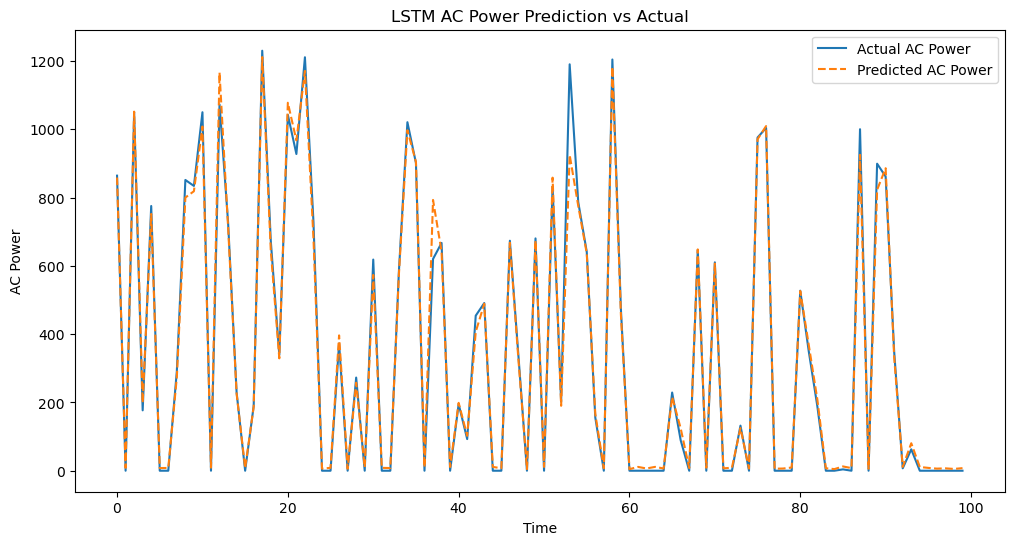

In [16]:
# Visualizing Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual AC Power")
plt.plot(lstm_predictions[:100], label="Predicted AC Power", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.title("LSTM AC Power Prediction vs Actual")
plt.show()